# Fully Connected Neural Networks: Architectures & Learning

## Learning Objectives

By the end of this lecture, you will be able to:

1. **Understand** why non-linear activation functions are essential for neural networks
2. **Build** multi-layer perceptrons (MLPs) from scratch using PyTorch
3. **Trace** forward propagation through a network step-by-step
4. **Explain** backpropagation intuitively and implement gradient checking
5. **Train** neural networks on real-world datasets (CIFAR-10)
6. **Apply** modern practices like proper initialization and optimization

In [1]:
# Essential imports for our neural network journey
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# For interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# For data loading
import torchvision
import torchvision.transforms as transforms

# Set style and random seeds for reproducibility
plt.style.use('seaborn-v0_8-darkgrid')
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
PyTorch Version: 2.8.0
CUDA Available: False


# Section 1: Why Neural Networks?
## Linear Models Can't Separate Non-linear Patterns

Linear models can only learn linear decision boundaries. The "two moons" dataset demonstrates this limitation: classes are intertwined in a non-linear pattern that no straight line can separate.


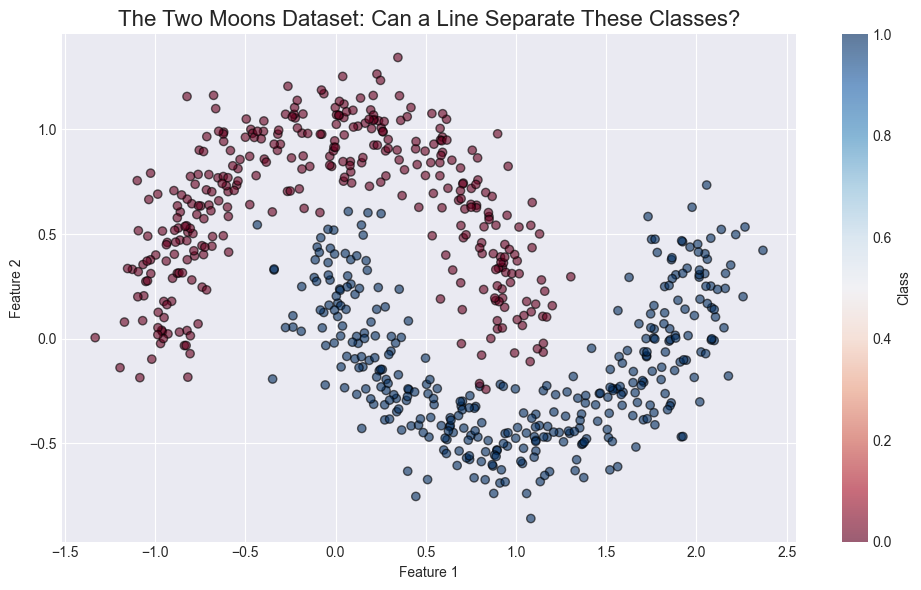

In [2]:
# Generate the famous two-moons dataset
X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdBu', alpha=0.6, edgecolors='k')
plt.title('The Two Moons Dataset: Can a Line Separate These Classes?', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()

## Logistic Regression Tries to Find a Linear Boundary

Logistic regression learns $\mathbf{w}$ and $b$ to define a decision boundary: $\mathbf{w}^T\mathbf{x} + b = 0$

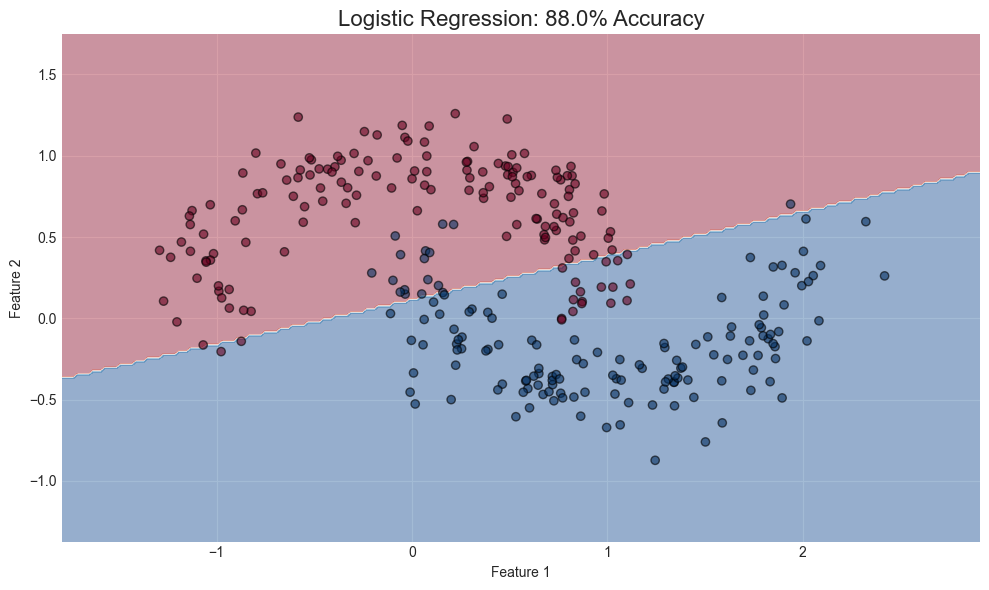

In [3]:
# Fit logistic regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Create a mesh for decision boundary visualization
def plot_decision_boundary(model, X, y, title, is_neural_net=False):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    if is_neural_net:
        # For PyTorch models
        with torch.no_grad():
            Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
            Z = (Z > 0.5).astype(int).reshape(xx.shape)
    else:
        # For sklearn models
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.6)
    plt.title(title, fontsize=16)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.tight_layout()
    plt.show()

# Plot linear decision boundary
plot_decision_boundary(log_reg, X_test, y_test, 
                      f'Logistic Regression: {log_reg.score(X_test, y_test):.1%} Accuracy')

## Neural Networks Learn Non-linear Boundaries

Logistic regression achieves only ~88% accuracy because it lacks the capacity to express curved decision boundaries. 

Neural networks overcome this through:
1. Composition of functions (multiple layers)
2. Non-linear activation functions

In [4]:
# Let's build a simple neural network that can solve this problem
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, output_size=1):  # Increased hidden size
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)  # Added hidden layer
        self.fc3 = nn.Linear(hidden_size//2, output_size)  # Added output layer
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))  # Added ReLU activation
        x = torch.sigmoid(self.fc3(x))  # Changed to fc3
        return x

# Quick training of the neural network
def train_simple_nn(X, y, epochs=300):  # Increased epochs
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    # Create model
    model = SimpleNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop (simplified for demonstration)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            accuracy = ((outputs > 0.5).float() == y_tensor).float().mean()
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2%}')
    
    return model

# Train the model
print("Training Neural Network...")
nn_model = train_simple_nn(X_train, y_train)

Training Neural Network...
Epoch 0, Loss: 0.7011, Accuracy: 49.14%
Epoch 50, Loss: 0.1516, Accuracy: 93.86%
Epoch 100, Loss: 0.0280, Accuracy: 99.43%
Epoch 150, Loss: 0.0159, Accuracy: 99.57%
Epoch 200, Loss: 0.0122, Accuracy: 99.57%
Epoch 250, Loss: 0.0102, Accuracy: 99.71%


## Universal Approximation Theorem

A neural network with a single hidden layer can approximate any continuous function to arbitrary accuracy (given sufficient neurons).

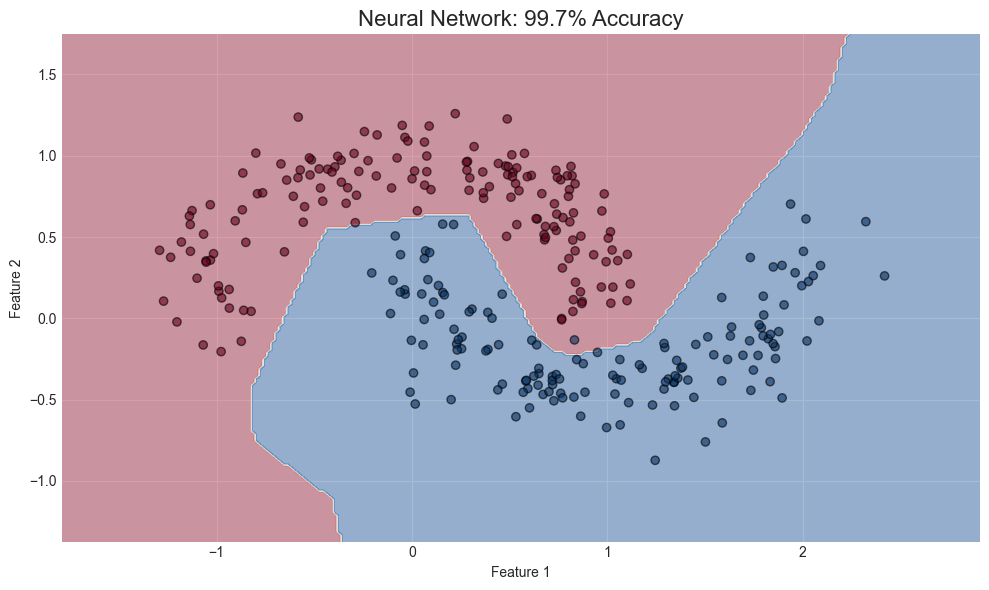


Linear Model: 88.0% accuracy
Neural Network: 99.7% accuracy
Improvement: 11.7%


In [5]:
# Evaluate and visualize neural network
nn_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    predictions = (nn_model(X_test_tensor) > 0.5).float()
    nn_accuracy = (predictions.squeeze() == y_test_tensor).float().mean()

plot_decision_boundary(nn_model, X_test, y_test, 
                      f'Neural Network: {nn_accuracy:.1%} Accuracy', 
                      is_neural_net=True)

print(f"\nLinear Model: {log_reg.score(X_test, y_test):.1%} accuracy")
print(f"Neural Network: {nn_accuracy:.1%} accuracy")
print(f"Improvement: {(nn_accuracy - log_reg.score(X_test, y_test)):.1%}")

# Section 2: From Perceptron to Neural Networks
## The Artificial Neuron

A neuron computes:
1. Weighted sum: $z = \mathbf{w}^T\mathbf{x} + b = \sum_{i=1}^{n} w_i x_i + b$
2. Activation: $a = f(z)$

## The Perceptron (1958)

Used a step activation function:
$$f(z) = \begin{cases} 
1 & \text{if } z > 0 \\
0 & \text{if } z \leq 0
\end{cases}$$

Limitation: Can't learn XOR (Minsky & Papert, 1969), leading to the first AI winter.


In [6]:
# Interactive neuron visualization
def visualize_single_neuron(w1=1.0, w2=0.5, bias=-0.5, activation='linear'):
    """Visualize a single neuron's operation"""
    # Create input grid
    x1 = np.linspace(-2, 2, 100)
    x2 = np.linspace(-2, 2, 100)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Compute weighted sum
    Z = w1 * X1 + w2 * X2 + bias
    
    # Apply activation function
    activations = {
        'linear': lambda x: x,
        'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
        'tanh': lambda x: np.tanh(x),
        'relu': lambda x: np.maximum(0, x),
        'step': lambda x: (x > 0).astype(float)
    }
    
    A = activations[activation](Z)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left: Weighted sum (using plain text instead of subscripts)
    im1 = ax1.contourf(X1, X2, Z, levels=20, cmap='RdBu')
    ax1.contour(X1, X2, Z, levels=[0], colors='black', linewidths=2)
    ax1.set_title(f'Weighted Sum: {w1}x x1 + {w2}x x2 + {bias}', fontsize=14)
    ax1.set_xlabel('Input x1')
    ax1.set_ylabel('Input x2')
    plt.colorbar(im1, ax=ax1)
    
    # Right: After activation (using plain text instead of subscripts)
    im2 = ax2.contourf(X1, X2, A, levels=20, cmap='RdBu')
    ax2.set_title(f'After {activation.upper()} Activation', fontsize=14)
    ax2.set_xlabel('Input x1')
    ax2.set_ylabel('Input x2')
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

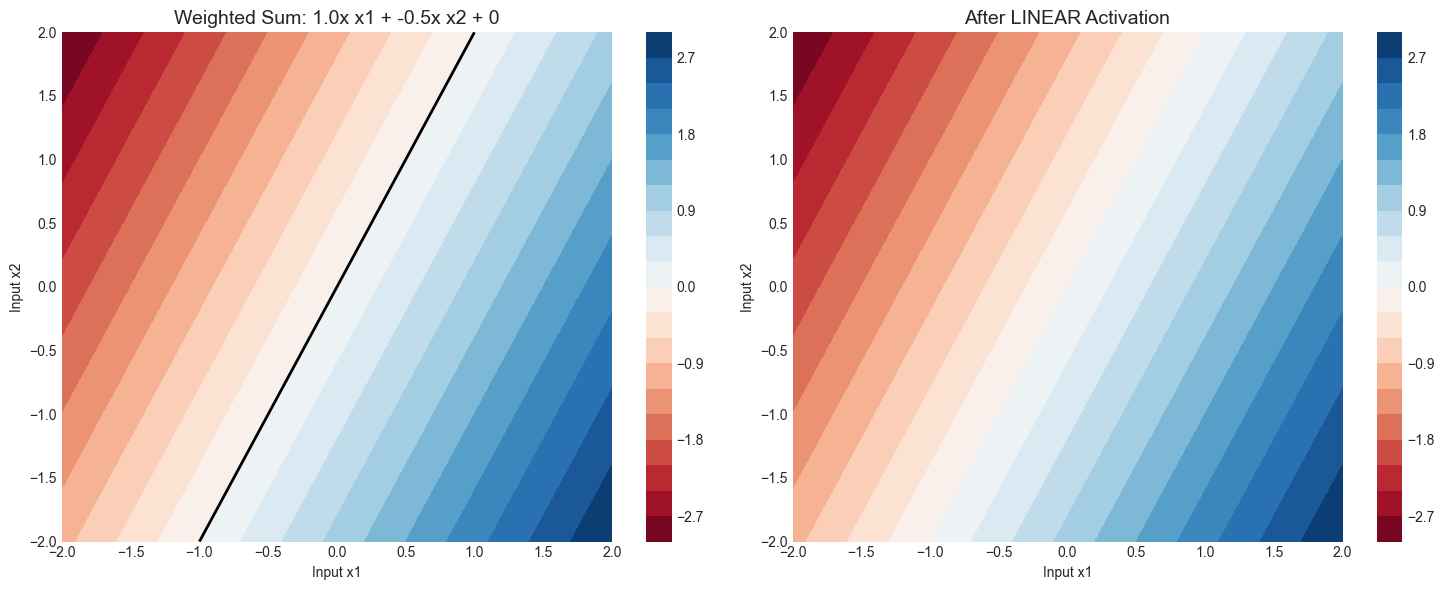

In [7]:
# Linear activation (no transformation)
visualize_single_neuron(w1=1.0, w2=-0.5, bias=0, activation='linear')

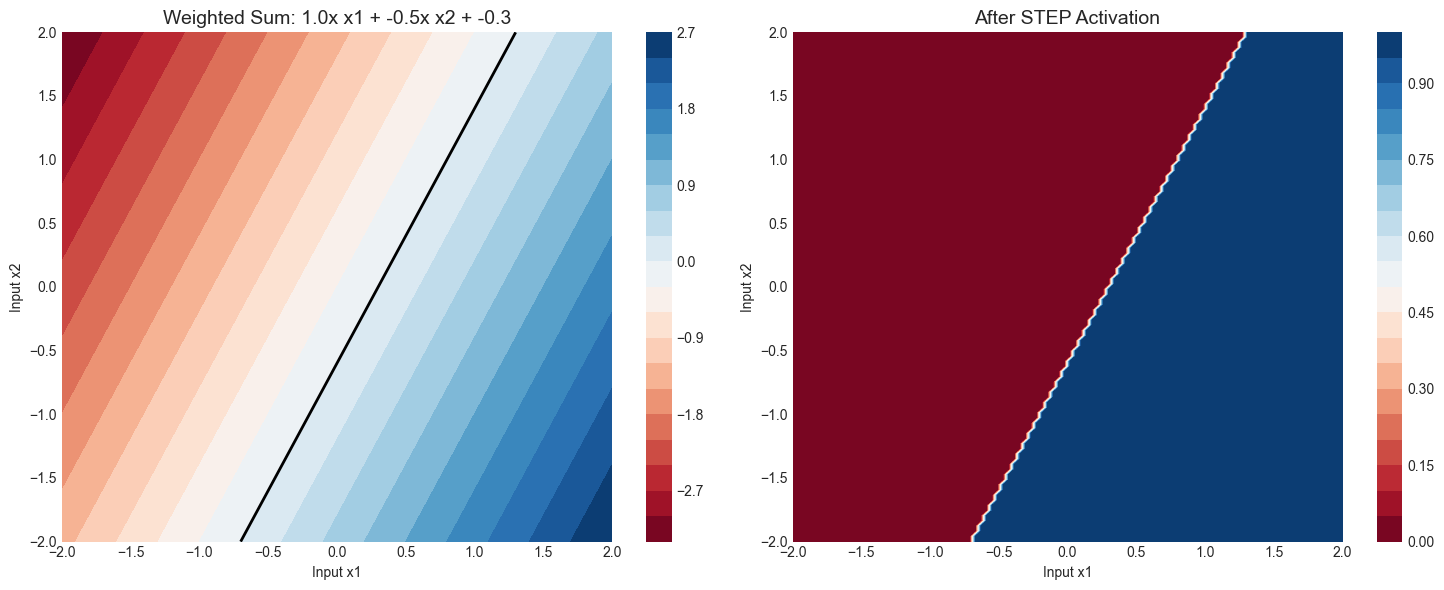

In [8]:
# Perceptron with step activation
visualize_single_neuron(w1=1.0, w2=-0.5, bias=-0.3, activation='step')

# Non-linear Activation Functions

Smooth, non-linear activations enable:
1. Gradient-based learning (well-defined gradients)
2. Multi-layer expressiveness (without them, multiple layers collapse to one)
3. Universal approximation

Common activations:
- **Sigmoid**: $\sigma(z) = \frac{1}{1 + e^{-z}}$ (range: 0 to 1)
- **Tanh**: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ (range: -1 to 1)
- **ReLU**: $\text{ReLU}(z) = \max(0, z)$ (range: 0 to ∞)

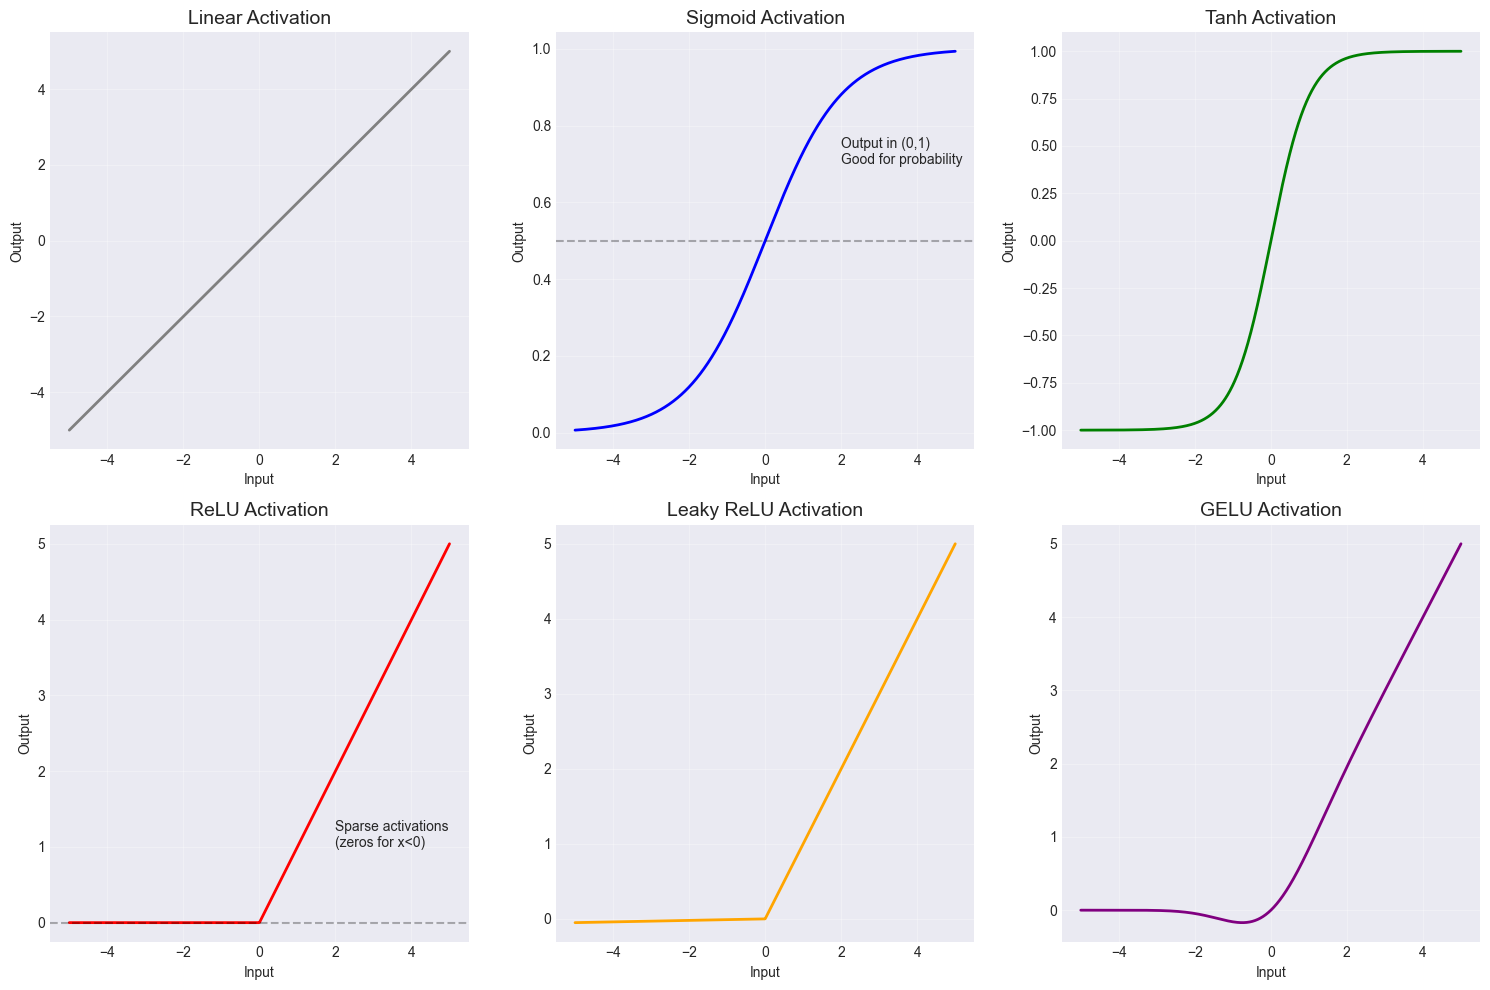

In [9]:
# Compare all major activation functions
def plot_activation_functions():
    x = np.linspace(-5, 5, 1000)
    
    activations = {
        'Linear': (lambda x: x, 'gray'),
        'Sigmoid': (lambda x: 1/(1+np.exp(-x)), 'blue'),
        'Tanh': (lambda x: np.tanh(x), 'green'),
        'ReLU': (lambda x: np.maximum(0, x), 'red'),
        'Leaky ReLU': (lambda x: np.where(x > 0, x, 0.01*x), 'orange'),
        'GELU': (lambda x: 0.5*x*(1 + np.tanh(np.sqrt(2/np.pi)*(x + 0.044715*x**3))), 'purple')
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (name, (func, color)) in enumerate(activations.items()):
        ax = axes[idx]
        y = func(x)
        ax.plot(x, y, color=color, linewidth=2)
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{name} Activation', fontsize=14)
        ax.set_xlabel('Input')
        ax.set_ylabel('Output')
        
        # Add key properties (using plain text instead of symbols)
        if name == 'ReLU':
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
            ax.text(2, 1, 'Sparse activations\n(zeros for x<0)', fontsize=10)
        elif name == 'Sigmoid':
            ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
            ax.text(2, 0.7, 'Output in (0,1)\nGood for probability', fontsize=10)  # Changed ∈ to "in"
    
    plt.tight_layout()
    plt.show()

plot_activation_functions()

## Why ReLU Dominates

ReLU ($\text{ReLU}(z) = \max(0, z)$) is the default activation because it's:
1. Computationally efficient (simple comparison)
2. Sparse (many exact zeros)
3. Has good gradients (no vanishing for $z > 0$)
4. Empirically superior


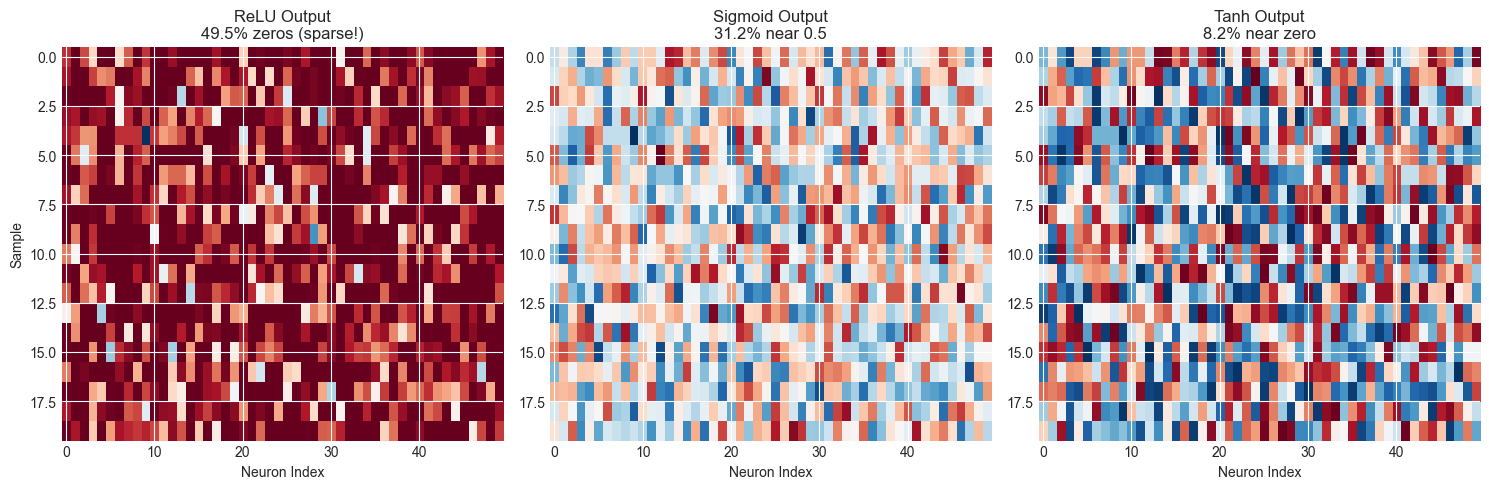

In [10]:
# Demonstrate ReLU sparsity on random data
def demonstrate_relu_sparsity():
    # Create random input data
    np.random.seed(42)
    input_data = np.random.randn(100, 50)  # 100 samples, 50 features
    
    # Apply different activations
    relu_output = np.maximum(0, input_data)
    sigmoid_output = 1 / (1 + np.exp(-input_data))
    tanh_output = np.tanh(input_data)
    
    # Calculate sparsity (percentage of zeros/near-zeros)
    relu_sparsity = (relu_output == 0).mean() * 100
    sigmoid_sparsity = (np.abs(sigmoid_output - 0.5) < 0.1).mean() * 100
    tanh_sparsity = (np.abs(tanh_output) < 0.1).mean() * 100
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    im1 = axes[0].imshow(relu_output[:20], cmap='RdBu', aspect='auto')
    axes[0].set_title(f'ReLU Output\n{relu_sparsity:.1f}% zeros (sparse!)', fontsize=12)
    axes[0].set_xlabel('Neuron Index')
    axes[0].set_ylabel('Sample')
    
    im2 = axes[1].imshow(sigmoid_output[:20], cmap='RdBu', aspect='auto')
    axes[1].set_title(f'Sigmoid Output\n{sigmoid_sparsity:.1f}% near 0.5', fontsize=12)
    axes[1].set_xlabel('Neuron Index')
    
    im3 = axes[2].imshow(tanh_output[:20], cmap='RdBu', aspect='auto')
    axes[2].set_title(f'Tanh Output\n{tanh_sparsity:.1f}% near zero', fontsize=12)
    axes[2].set_xlabel('Neuron Index')
    
    plt.tight_layout()
    plt.show()

demonstrate_relu_sparsity()

ReLU creates sparse representations, leading to faster computation and better feature learning (Glorot et al., 2011).

## Why Non-linearity is Essential

Without non-linear activations, deep networks collapse to linear models.

Two linear layers:
- $\mathbf{y} = \mathbf{W}_1\mathbf{x} + \mathbf{b}_1$
- $\mathbf{z} = \mathbf{W}_2\mathbf{y} + \mathbf{b}_2$

Combine them:
$$\mathbf{z} = (\mathbf{W}_2\mathbf{W}_1)\mathbf{x} + (\mathbf{W}_2\mathbf{b}_1 + \mathbf{b}_2)$$

This is still just one linear transformation! Stacking more linear layers doesn't help.

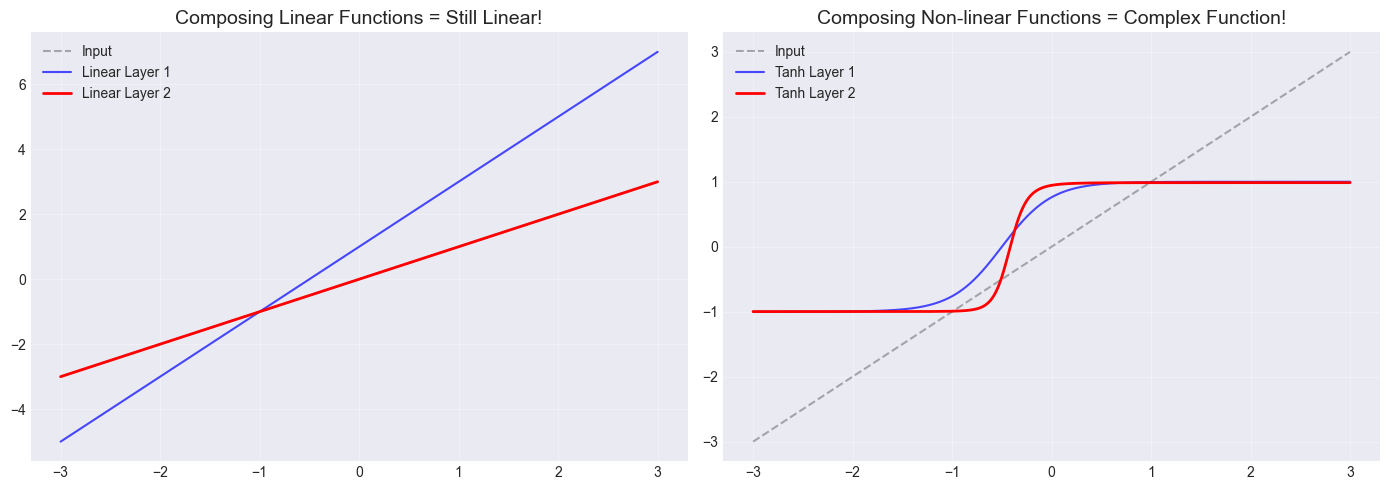

In [11]:
# Visual proof: Linear vs Non-linear composition
def show_function_composition():
    x = np.linspace(-3, 3, 1000)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Linear composition
    ax1 = axes[0]
    linear1 = 2 * x + 1
    linear2 = 0.5 * linear1 - 0.5
    ax1.plot(x, x, 'k--', alpha=0.3, label='Input')
    ax1.plot(x, linear1, 'b-', alpha=0.7, label='Linear Layer 1')
    ax1.plot(x, linear2, 'r-', linewidth=2, label='Linear Layer 2')
    ax1.set_title('Composing Linear Functions = Still Linear!', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Non-linear composition
    ax2 = axes[1]
    nonlinear1 = np.tanh(2 * x + 1)
    nonlinear2 = np.tanh(3 * nonlinear1 - 0.5)
    ax2.plot(x, x, 'k--', alpha=0.3, label='Input')
    ax2.plot(x, nonlinear1, 'b-', alpha=0.7, label='Tanh Layer 1')
    ax2.plot(x, nonlinear2, 'r-', linewidth=2, label='Tanh Layer 2')
    ax2.set_title('Composing Non-linear Functions = Complex Function!', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

show_function_composition()

# Section 3: Multi-Layer Perceptrons (MLPs)

An MLP consists of:
1. **Input Layer**: Raw features
2. **Hidden Layers**: Learn representations
3. **Output Layer**: Final predictions

Each layer transforms data into increasingly abstract features.


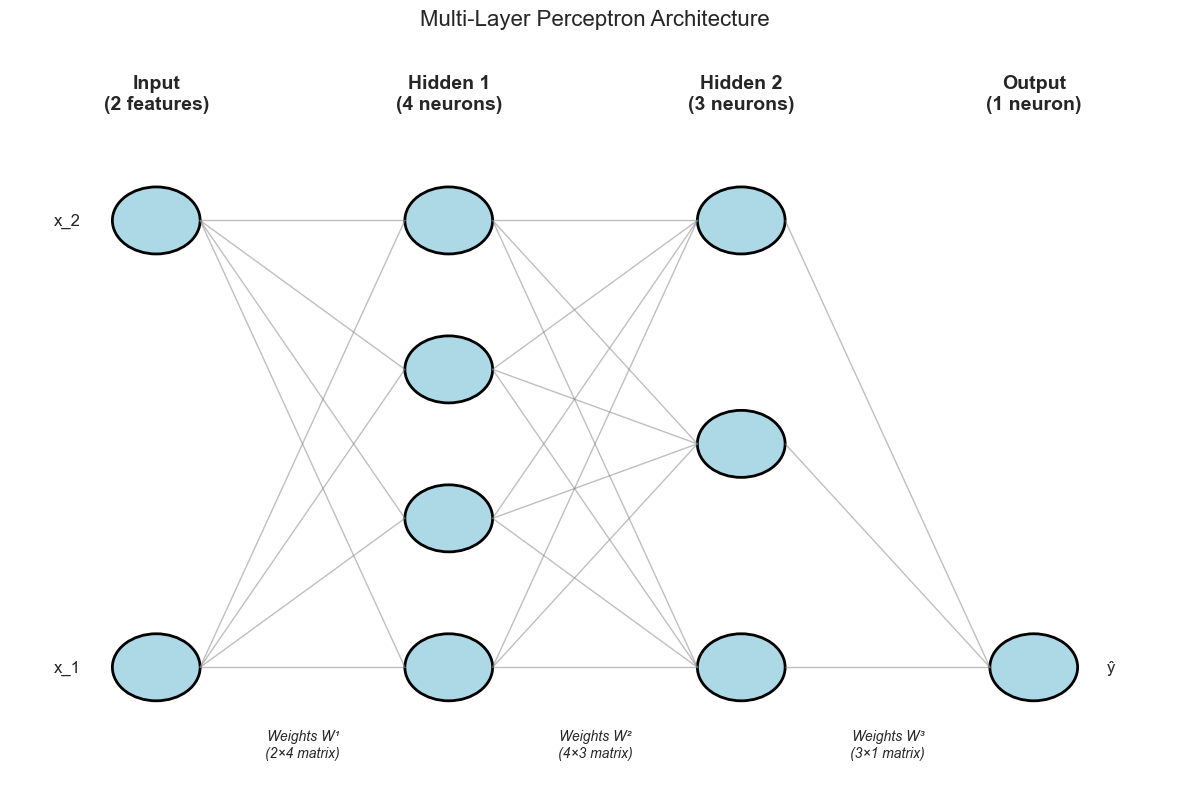

Total parameters: 31
  - Layer 1: 2×4 weights + 4 biases = 12 parameters
  - Layer 2: 4×3 weights + 3 biases = 15 parameters
  - Layer 3: 3×1 weights + 1 bias  = 4 parameters


In [12]:
# Visualize MLP architecture
def draw_mlp_architecture():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Layer positions
    layers = [2, 4, 3, 1]  # neurons per layer
    layer_names = ['Input\n(2 features)', 'Hidden 1\n(4 neurons)', 
                   'Hidden 2\n(3 neurons)', 'Output\n(1 neuron)']
    x_positions = [1, 3, 5, 7]
    
    # Draw neurons
    neuron_positions = {}
    for layer_idx, (n_neurons, x) in enumerate(zip(layers, x_positions)):
        y_positions = np.linspace(1, 5, n_neurons)
        for neuron_idx, y in enumerate(y_positions):
            circle = plt.Circle((x, y), 0.3, color='lightblue', ec='black', linewidth=2)
            ax.add_patch(circle)
            neuron_positions[(layer_idx, neuron_idx)] = (x, y)
            
            # Add labels for special neurons
            if layer_idx == 0:
                ax.text(x-0.7, y, f'x_{neuron_idx+1}', fontsize=12, va='center')
            elif layer_idx == len(layers)-1:
                ax.text(x+0.5, y, 'ŷ', fontsize=12, va='center')
    
    # Draw connections
    for layer_idx in range(len(layers)-1):
        for from_neuron in range(layers[layer_idx]):
            for to_neuron in range(layers[layer_idx+1]):
                from_pos = neuron_positions[(layer_idx, from_neuron)]
                to_pos = neuron_positions[(layer_idx+1, to_neuron)]
                ax.plot([from_pos[0]+0.3, to_pos[0]-0.3], 
                       [from_pos[1], to_pos[1]], 
                       'gray', alpha=0.5, linewidth=1)
    
    # Add layer labels
    for x, name in zip(x_positions, layer_names):
        ax.text(x, 6, name, fontsize=14, ha='center', weight='bold')
    
    # Add annotations
    ax.text(2, 0.2, 'Weights W¹\n(2×4 matrix)', fontsize=10, ha='center', style='italic')
    ax.text(4, 0.2, 'Weights W²\n(4×3 matrix)', fontsize=10, ha='center', style='italic')
    ax.text(6, 0.2, 'Weights W³\n(3×1 matrix)', fontsize=10, ha='center', style='italic')
    
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 6.5)
    ax.axis('off')
    ax.set_title('Multi-Layer Perceptron Architecture', fontsize=16, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate total parameters
    total_params = (2*4 + 4) + (4*3 + 3) + (3*1 + 1)
    print(f"Total parameters: {total_params}")
    print(f"  - Layer 1: 2×4 weights + 4 biases = 12 parameters")
    print(f"  - Layer 2: 4×3 weights + 3 biases = 15 parameters")
    print(f"  - Layer 3: 3×1 weights + 1 bias  = 4 parameters")

draw_mlp_architecture()

## Building an MLP in PyTorch

Use `nn.Module` to define layers and implement the forward pass.


In [13]:
# Define a flexible MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        super(MLP, self).__init__()
        
        # Build layers
        self.layers = nn.ModuleList()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        
        # Select activation function
        self.activation = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }[activation]
    
    def forward(self, x):
        # Forward pass through all layers
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Apply activation to all but last layer
            if i < len(self.layers) - 1:
                x = self.activation(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification

# Create the model from our diagram
model = MLP(input_size=2, hidden_sizes=[4, 3], output_size=1)
print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params}")

# Show parameter shapes
print("\nParameter shapes:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.shape}")

Model Architecture:
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=3, bias=True)
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
  (activation): ReLU()
)

Total parameters: 31

Parameter shapes:
  layers.0.weight: torch.Size([4, 2])
  layers.0.bias: torch.Size([4])
  layers.1.weight: torch.Size([3, 4])
  layers.1.bias: torch.Size([3])
  layers.2.weight: torch.Size([1, 3])
  layers.2.bias: torch.Size([1])


## Complex Decision Boundaries from Simple Parts

Each neuron learns a linear boundary. Combined through non-linear activations, these compose into complex shapes.

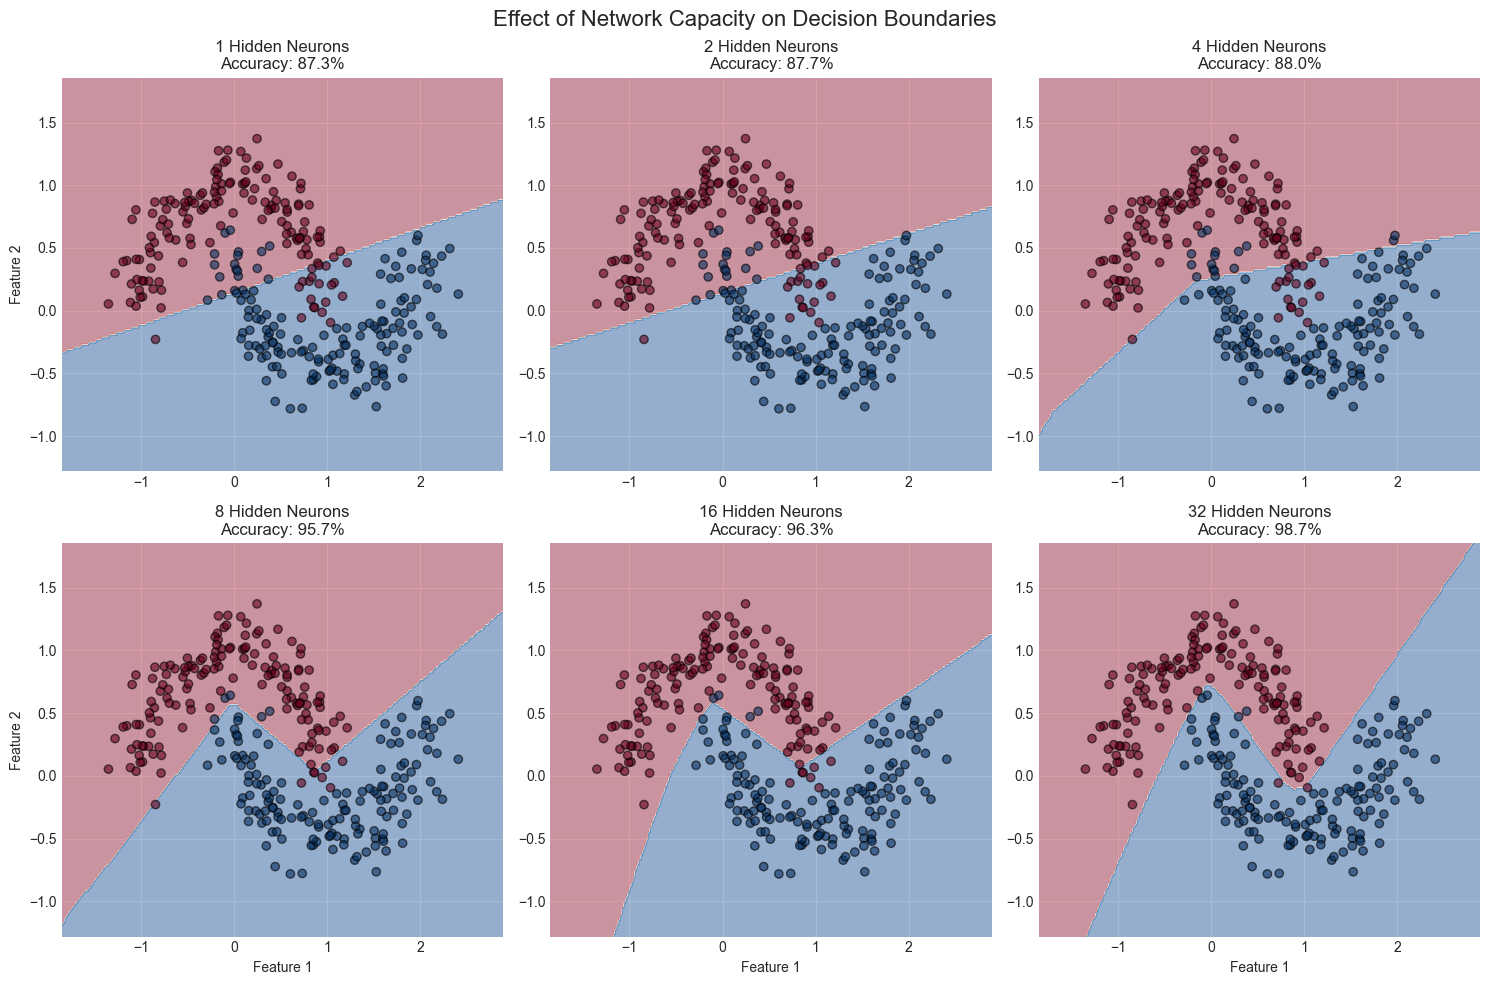

In [14]:
# Interactive visualization: How neurons combine
def visualize_neuron_combination(n_neurons=4):
    # Generate data
    X, y = make_moons(n_samples=300, noise=0.15, random_state=42)
    
    # Train models with different numbers of neurons
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    neuron_counts = [1, 2, 4, 8, 16, 32]
    
    for idx, n in enumerate(neuron_counts):
        # Create and train model
        model = MLP(input_size=2, hidden_sizes=[n], output_size=1)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.BCELoss()
        
        # Convert data to tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y).reshape(-1, 1)
        
        # Quick training
        model.train()
        for epoch in range(300):
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        
        # Plot decision boundary
        model.eval()
        ax = axes[idx]
        
        # Create mesh
        h = 0.02
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        
        with torch.no_grad():
            Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
            Z = (Z.numpy() > 0.5).astype(int).reshape(xx.shape)
        
        ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.6)
        
        # Calculate accuracy
        with torch.no_grad():
            predictions = (model(X_tensor) > 0.5).float()
            accuracy = (predictions.squeeze() == y_tensor.squeeze()).float().mean()
        
        ax.set_title(f'{n} Hidden Neurons\nAccuracy: {accuracy:.1%}', fontsize=12)
        ax.set_xlabel('Feature 1' if idx >= 3 else '')
        ax.set_ylabel('Feature 2' if idx % 3 == 0 else '')
    
    plt.suptitle('Effect of Network Capacity on Decision Boundaries', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_neuron_combination()

## Capacity vs Complexity

- **1-2 neurons**: Underfitting (too simple)
- **4-8 neurons**: Good fit (right capacity)
- **16-32 neurons**: Overfitting (memorizes noise)

Finding the right architecture for your problem is key.

# Section 4: Forward Propagation

Input data flows through the network layer by layer to produce predictions.


In [15]:
# Create a tiny network for manual forward propagation
class TinyNetwork(nn.Module):
    def __init__(self):
        super(TinyNetwork, self).__init__()
        # Define small weights for easy calculation
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 1)
        
        # Set specific weights for demonstration
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(torch.tensor([[1.0, -0.5], 
                                                         [0.5, 1.0], 
                                                         [-1.0, 0.5]]))
            self.fc1.bias = nn.Parameter(torch.tensor([0.0, -0.5, 1.0]))
            
            self.fc2.weight = nn.Parameter(torch.tensor([[1.0, -1.0, 0.5]]))
            self.fc2.bias = nn.Parameter(torch.tensor([0.5]))
    
    def forward(self, x, verbose=False):
        if verbose:
            print("=== Forward Propagation Trace ===")
            print(f"Input: {x.numpy()}")
            
        # Layer 1
        z1 = self.fc1(x)
        if verbose:
            print(f"\nLayer 1 (Linear):")
            print(f"  Weights:\n{self.fc1.weight.detach().numpy()}")
            print(f"  Bias: {self.fc1.bias.detach().numpy()}")
            print(f"  z1 = Wx + b = {z1.detach().numpy()}")
        
        a1 = torch.relu(z1)
        if verbose:
            print(f"  After ReLU: a1 = {a1.detach().numpy()}")
        
        # Layer 2
        z2 = self.fc2(a1)
        if verbose:
            print(f"\nLayer 2 (Linear):")
            print(f"  Weights: {self.fc2.weight.detach().numpy()}")
            print(f"  Bias: {self.fc2.bias.detach().numpy()}")
            print(f"  z2 = Wa + b = {z2.detach().numpy()}")
        
        output = torch.sigmoid(z2)
        if verbose:
            print(f"  After Sigmoid: output = {output.detach().numpy()}")
            print("=" * 40)
        
        return output

# Demonstrate forward propagation
tiny_net = TinyNetwork()
sample_input = torch.tensor([1.0, 2.0])
output = tiny_net(sample_input, verbose=True)

=== Forward Propagation Trace ===
Input: [1. 2.]

Layer 1 (Linear):
  Weights:
[[ 1.  -0.5]
 [ 0.5  1. ]
 [-1.   0.5]]
  Bias: [ 0.  -0.5  1. ]
  z1 = Wx + b = [0. 2. 1.]
  After ReLU: a1 = [0. 2. 1.]

Layer 2 (Linear):
  Weights: [[ 1.  -1.   0.5]]
  Bias: [0.5]
  z2 = Wa + b = [-1.]
  After Sigmoid: output = [0.26894143]


## Visualizing Forward Propagation

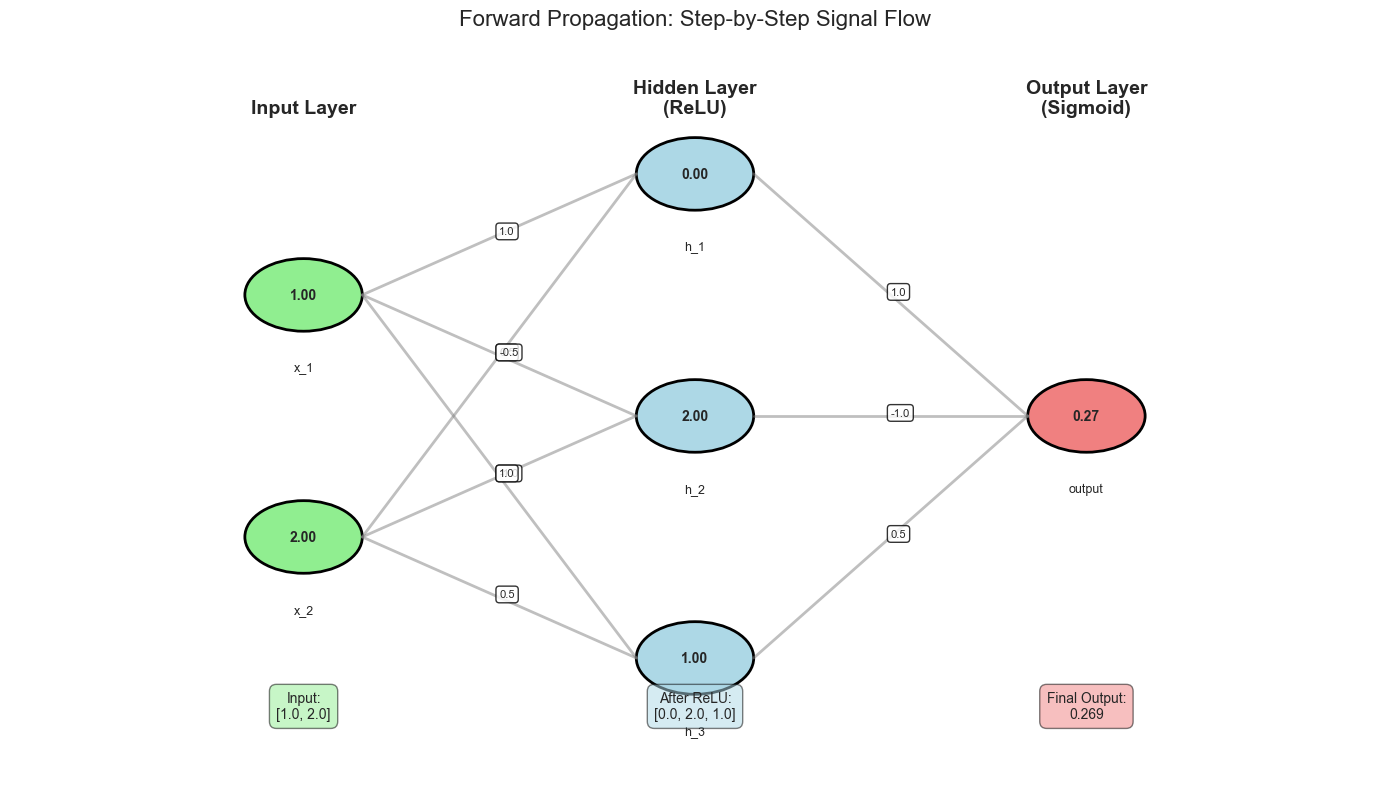

In [16]:
# Create an interactive forward propagation visualizer
def visualize_forward_prop():
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Network structure
    input_neurons = [(-1, 1), (-1, -1)]
    hidden_neurons = [(1, 2), (1, 0), (1, -2)]
    output_neuron = [(3, 0)]
    
    # Draw neurons with values
    def draw_neuron(pos, value, label, color='lightblue'):
        circle = plt.Circle(pos, 0.3, color=color, ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(pos[0], pos[1], f'{value:.2f}', ha='center', va='center', fontsize=10, weight='bold')
        ax.text(pos[0], pos[1]-0.6, label, ha='center', va='center', fontsize=9)
    
    # Input values
    x = [1.0, 2.0]
    
    # Forward pass calculations (matching our tiny network)
    # Layer 1
    z1_0 = 1.0*1.0 + (-0.5)*2.0 + 0.0  # = 0.0
    z1_1 = 0.5*1.0 + 1.0*2.0 + (-0.5)   # = 2.0
    z1_2 = (-1.0)*1.0 + 0.5*2.0 + 1.0   # = 1.0
    
    a1 = [max(0, z1_0), max(0, z1_1), max(0, z1_2)]  # [0.0, 2.0, 1.0]
    
    # Layer 2
    z2 = 1.0*a1[0] + (-1.0)*a1[1] + 0.5*a1[2] + 0.5  # = -1.0
    output = 1 / (1 + np.exp(-z2))  # ≈ 0.27
    
    # Draw neurons with calculated values
    for i, (pos, val) in enumerate(zip(input_neurons, x)):
        draw_neuron(pos, val, f'x_{i+1}', 'lightgreen')
    
    for i, (pos, val) in enumerate(zip(hidden_neurons, a1)):
        draw_neuron(pos, val, f'h_{i+1}', 'lightblue')
    
    draw_neuron(output_neuron[0], output, 'output', 'lightcoral')
    
    # Draw connections with weights
    connections = [
        # From input to hidden
        (input_neurons[0], hidden_neurons[0], '1.0'),
        (input_neurons[0], hidden_neurons[1], '0.5'),
        (input_neurons[0], hidden_neurons[2], '-1.0'),
        (input_neurons[1], hidden_neurons[0], '-0.5'),
        (input_neurons[1], hidden_neurons[1], '1.0'),
        (input_neurons[1], hidden_neurons[2], '0.5'),
        # From hidden to output
        (hidden_neurons[0], output_neuron[0], '1.0'),
        (hidden_neurons[1], output_neuron[0], '-1.0'),
        (hidden_neurons[2], output_neuron[0], '0.5'),
    ]
    
    for start, end, weight in connections:
        ax.plot([start[0]+0.3, end[0]-0.3], [start[1], end[1]], 
               'gray', alpha=0.5, linewidth=2)
        # Add weight label
        mid_x = (start[0] + end[0]) / 2
        mid_y = (start[1] + end[1]) / 2
        ax.text(mid_x, mid_y, weight, fontsize=8, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Add layer labels
    ax.text(-1, 2.5, 'Input Layer', fontsize=14, ha='center', weight='bold')
    ax.text(1, 2.5, 'Hidden Layer\n(ReLU)', fontsize=14, ha='center', weight='bold')
    ax.text(3, 2.5, 'Output Layer\n(Sigmoid)', fontsize=14, ha='center', weight='bold')
    
    # Add computation annotations
    ax.text(-1, -2.5, 'Input:\n[1.0, 2.0]', fontsize=10, ha='center', 
           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.5))
    
    ax.text(1, -2.5, 'After ReLU:\n[0.0, 2.0, 1.0]', fontsize=10, ha='center',
           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.5))
    
    ax.text(3, -2.5, f'Final Output:\n{output:.3f}', fontsize=10, ha='center',
           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.5))
    
    ax.set_xlim(-2.5, 4.5)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    ax.set_title('Forward Propagation: Step-by-Step Signal Flow', fontsize=16, pad=20)
    
    plt.tight_layout()
    plt.show()

visualize_forward_prop()

## Matrix Operations for Efficiency

Real neural networks use matrix operations for parallel processing on GPUs:
$$\mathbf{Z} = \mathbf{X}\mathbf{W}^T + \mathbf{b}$$
$$\mathbf{A} = f(\mathbf{Z})$$

In [17]:
# Show the same forward pass using matrix operations
def forward_prop_matrix_view():
    print("=== Forward Propagation: Matrix View ===\n")
    
    # Input
    X = torch.tensor([[1.0, 2.0]])  # Shape: (1, 2)
    print(f"Input X: {X.shape}")
    print(X)
    
    # Layer 1 weights and bias
    W1 = torch.tensor([[1.0, -0.5], 
                       [0.5, 1.0], 
                       [-1.0, 0.5]])  # Shape: (3, 2)
    b1 = torch.tensor([0.0, -0.5, 1.0])  # Shape: (3,)
    
    print(f"\nLayer 1 - Weight matrix W1: {W1.shape}")
    print(W1)
    print(f"\nBias vector b1: {b1.shape}")
    print(b1)
    
    # Forward pass Layer 1
    Z1 = X @ W1.T + b1  # Matrix multiplication + bias
    print(f"\nZ1 = X @ W1.T + b1: {Z1.shape}")
    print(Z1)
    
    A1 = torch.relu(Z1)
    print(f"\nA1 = ReLU(Z1): {A1.shape}")
    print(A1)
    
    # Layer 2
    W2 = torch.tensor([[1.0, -1.0, 0.5]])  # Shape: (1, 3)
    b2 = torch.tensor([0.5])  # Shape: (1,)
    
    print(f"\nLayer 2 - Weight matrix W2: {W2.shape}")
    print(W2)
    
    Z2 = A1 @ W2.T + b2
    print(f"\nZ2 = A1 @ W2.T + b2: {Z2.shape}")
    print(Z2)
    
    output = torch.sigmoid(Z2)
    print(f"\nOutput = Sigmoid(Z2): {output.shape}")
    print(output)

forward_prop_matrix_view()

=== Forward Propagation: Matrix View ===

Input X: torch.Size([1, 2])
tensor([[1., 2.]])

Layer 1 - Weight matrix W1: torch.Size([3, 2])
tensor([[ 1.0000, -0.5000],
        [ 0.5000,  1.0000],
        [-1.0000,  0.5000]])

Bias vector b1: torch.Size([3])
tensor([ 0.0000, -0.5000,  1.0000])

Z1 = X @ W1.T + b1: torch.Size([1, 3])
tensor([[0., 2., 1.]])

A1 = ReLU(Z1): torch.Size([1, 3])
tensor([[0., 2., 1.]])

Layer 2 - Weight matrix W2: torch.Size([1, 3])
tensor([[ 1.0000, -1.0000,  0.5000]])

Z2 = A1 @ W2.T + b2: torch.Size([1, 1])
tensor([[-1.]])

Output = Sigmoid(Z2): torch.Size([1, 1])
tensor([[0.2689]])


Matrix operations enable batch processing: multiple samples simultaneously.

# Section 5: Real Data - CIFAR-10

CIFAR-10: 60,000 32×32 color images across 10 classes
- 3,072 input features (32×32×3)
- Real-world variations in lighting, perspective, and appearance

In [18]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Image shape: {trainset[0][0].shape}")
print(f"Classes: {', '.join(classes)}")

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck


## Exploring CIFAR-10

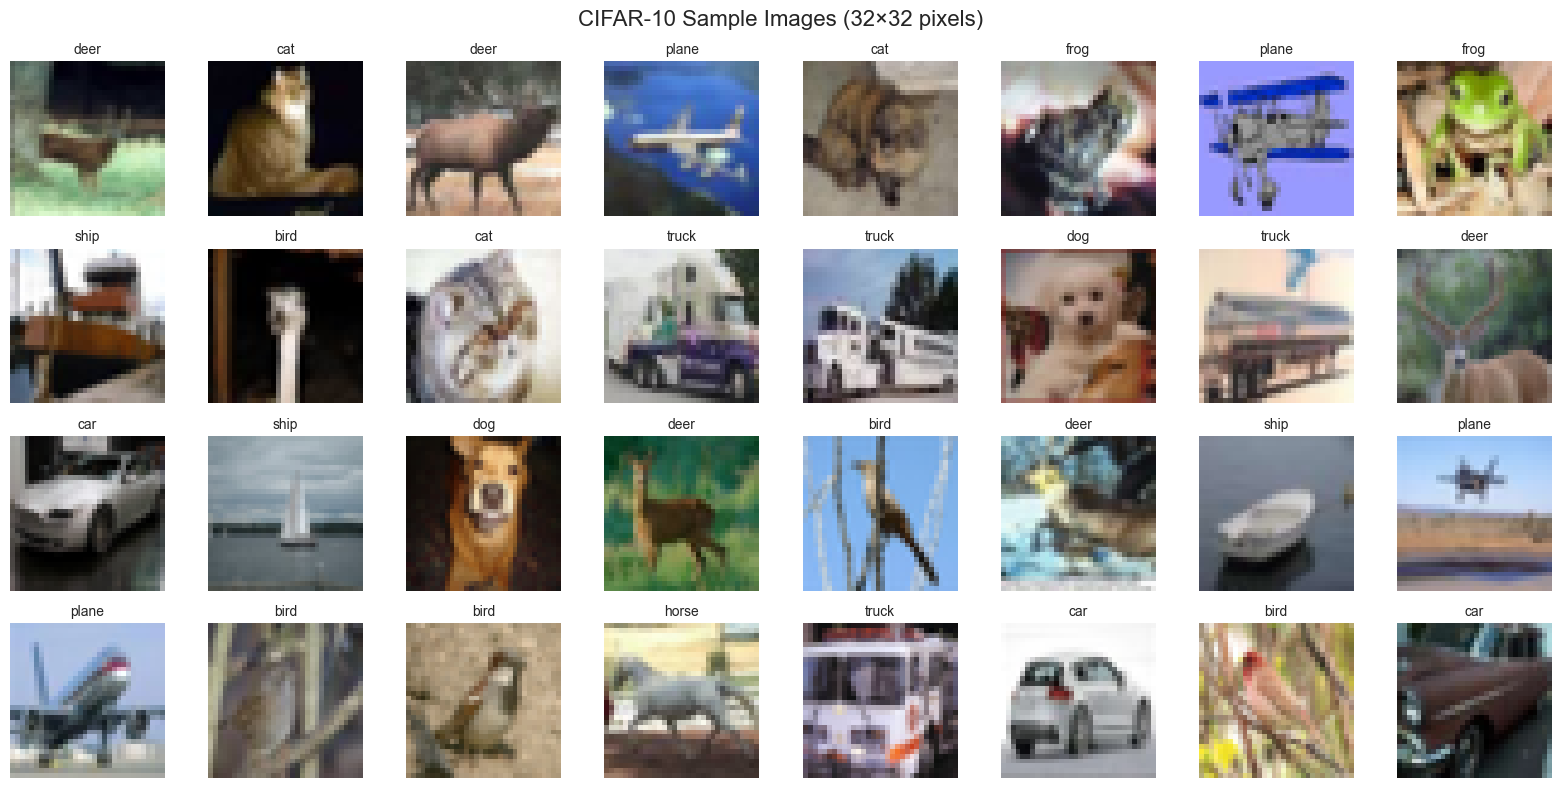

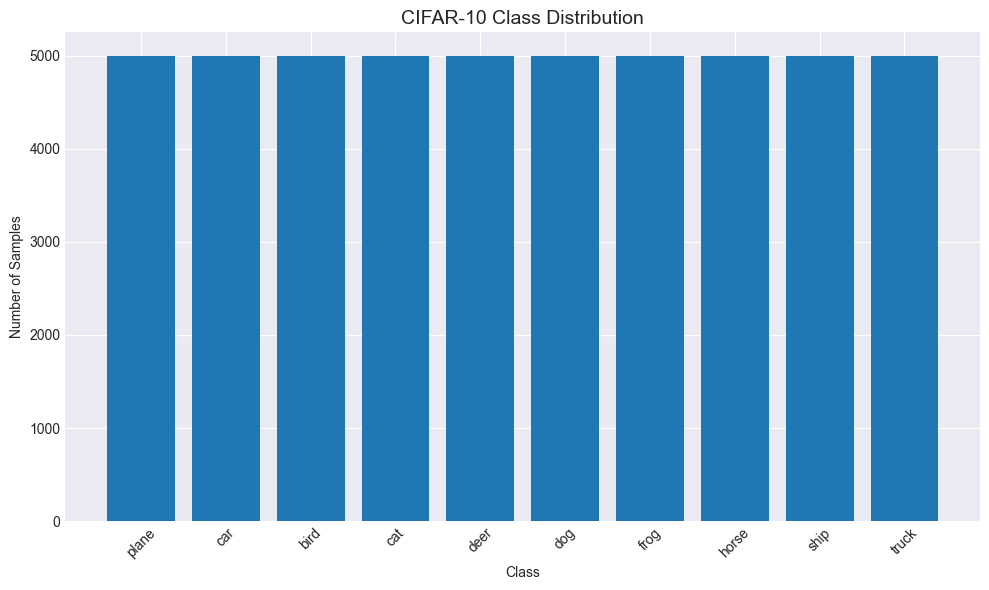

In [19]:
# Visualize CIFAR-10 samples
def show_cifar_samples():
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get one batch of data
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    
    # Denormalize images for display
    def denormalize(tensor):
        return tensor * 0.5 + 0.5
    
    for idx in range(32):
        img = denormalize(images[idx])
        img = np.transpose(img.numpy(), (1, 2, 0))
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'{classes[labels[idx]]}', fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle('CIFAR-10 Sample Images (32×32 pixels)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Show class distribution
    class_counts = torch.zeros(10)
    for _, labels in trainloader:
        for label in labels:
            class_counts[label] += 1
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, class_counts.numpy())
    plt.title('CIFAR-10 Class Distribution', fontsize=14)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

show_cifar_samples()

## Building an MLP for CIFAR-10

Architecture: 3,072 → 512 → 256 → 128 → 10
- Flatten 2D images to 1D (loses spatial information)
- Dropout for regularization

In [20]:
# Define MLP for CIFAR-10
class CIFAR10_MLP(nn.Module):
    def __init__(self):
        super(CIFAR10_MLP, self).__init__()
        # Input: 32*32*3 = 3072 features
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)  # 10 classes
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the image
        x = x.view(x.size(0), -1)
        
        # Forward through layers with ReLU and dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.fc4(x)  # No activation, will use CrossEntropyLoss
        return x

# Create model and count parameters
model_cifar = CIFAR10_MLP()
total_params = sum(p.numel() for p in model_cifar.parameters())
print(f"Model created with {total_params:,} parameters")
print("\nArchitecture:")
print(model_cifar)

Model created with 1,738,890 parameters

Architecture:
CIFAR10_MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Section 6: Backpropagation

Backpropagation uses the chain rule to compute gradients efficiently:
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial x}$$

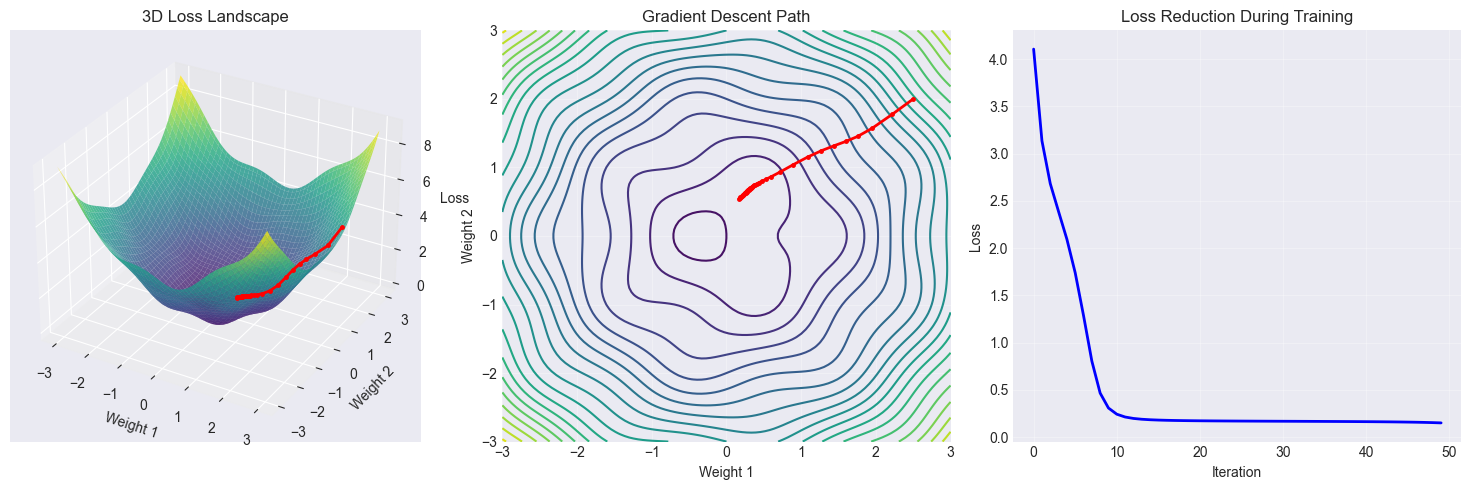

In [21]:
# Visualize the loss landscape and gradient descent
def visualize_loss_landscape():
    # Create a simple 2D loss landscape
    w1 = np.linspace(-3, 3, 100)
    w2 = np.linspace(-3, 3, 100)
    W1, W2 = np.meshgrid(w1, w2)
    
    # Define a loss function with interesting topology
    Z = 0.5 * (W1**2 + W2**2) + 0.3 * np.sin(3*W1) * np.cos(3*W2)
    
    # Gradient descent path
    path_w1, path_w2, path_loss = [], [], []
    w1_current, w2_current = 2.5, 2.0  # Starting point
    learning_rate = 0.1
    
    for _ in range(50):
        path_w1.append(w1_current)
        path_w2.append(w2_current)
        
        # Compute gradients (analytical for our function)
        grad_w1 = w1_current + 0.9 * np.cos(3*w1_current) * np.cos(3*w2_current)
        grad_w2 = w2_current - 0.9 * np.sin(3*w1_current) * np.sin(3*w2_current)
        
        # Update weights
        w1_current -= learning_rate * grad_w1
        w2_current -= learning_rate * grad_w2
        
        # Compute loss at current position
        loss = 0.5 * (w1_current**2 + w2_current**2) + \
               0.3 * np.sin(3*w1_current) * np.cos(3*w2_current)
        path_loss.append(loss)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(W1, W2, Z, cmap='viridis', alpha=0.8)
    ax1.plot(path_w1, path_w2, path_loss, 'r.-', linewidth=2, markersize=5)
    ax1.set_xlabel('Weight 1')
    ax1.set_ylabel('Weight 2')
    ax1.set_zlabel('Loss')
    ax1.set_title('3D Loss Landscape')
    
    # Contour plot
    ax2 = fig.add_subplot(132)
    cont = ax2.contour(W1, W2, Z, levels=20, cmap='viridis')
    ax2.plot(path_w1, path_w2, 'r.-', linewidth=2, markersize=5)
    ax2.set_xlabel('Weight 1')
    ax2.set_ylabel('Weight 2')
    ax2.set_title('Gradient Descent Path')
    ax2.grid(True, alpha=0.3)
    
    # Loss over iterations
    ax3 = fig.add_subplot(133)
    ax3.plot(path_loss, 'b-', linewidth=2)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss Reduction During Training')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_loss_landscape()

Gradient descent follows the steepest downhill path to minimize the loss function.

## Computing Gradients

For a weight $w_{ij}$:
$$\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial a_j} \cdot \frac{\partial a_j}{\partial z_j} \cdot \frac{\partial z_j}{\partial w_{ij}}$$

This efficiently reuses computations across the network.


In [22]:
# Demonstrate backpropagation with a simple example
def backprop_example():
    print("=== Backpropagation Example ===\n")
    
    # Simple network: input -> hidden (2 neurons) -> output
    # Using specific values for clarity
    x = torch.tensor([1.0, 2.0], requires_grad=True)
    w1 = torch.tensor([[0.5, -0.5], [1.0, 0.0]], requires_grad=True)
    b1 = torch.tensor([0.0, 0.5], requires_grad=True)
    w2 = torch.tensor([[1.0, -1.0]], requires_grad=True)
    b2 = torch.tensor([0.0], requires_grad=True)
    y_true = torch.tensor([1.0])
    
    print("Forward Pass:")
    print(f"Input x = {x.data}")
    
    # Forward pass
    z1 = x @ w1.T + b1
    print(f"z1 = x @ w1.T + b1 = {z1.data}")
    
    a1 = torch.relu(z1)
    print(f"a1 = ReLU(z1) = {a1.data}")
    
    z2 = a1 @ w2.T + b2
    print(f"z2 = a1 @ w2.T + b2 = {z2.data}")
    
    y_pred = torch.sigmoid(z2)
    print(f"y_pred = sigmoid(z2) = {y_pred.data}")
    
    # Compute loss
    loss = nn.BCELoss()(y_pred, y_true)
    print(f"\nLoss = {loss.item():.4f}")
    
    # Backward pass
    print("\n\nBackward Pass (Chain Rule):")
    loss.backward()
    
    print(f"∂L/∂w2 = {w2.grad.data}")
    print(f"∂L/∂b2 = {b2.grad.data}")
    print(f"∂L/∂w1 = \n{w1.grad.data}")
    print(f"∂L/∂b1 = {b1.grad.data}")
    print(f"∂L/∂x = {x.grad.data}")

backprop_example()

=== Backpropagation Example ===

Forward Pass:
Input x = tensor([1., 2.])
z1 = x @ w1.T + b1 = tensor([-0.5000,  1.5000])
a1 = ReLU(z1) = tensor([0.0000, 1.5000])
z2 = a1 @ w2.T + b2 = tensor([-1.5000])
y_pred = sigmoid(z2) = tensor([0.1824])

Loss = 1.7014


Backward Pass (Chain Rule):
∂L/∂w2 = tensor([[ 0.0000, -1.2264]])
∂L/∂b2 = tensor([-0.8176])
∂L/∂w1 = 
tensor([[0.0000, 0.0000],
        [0.8176, 1.6351]])
∂L/∂b1 = tensor([0.0000, 0.8176])
∂L/∂x = tensor([0.8176, 0.0000])


## Gradient Checking

Verify backpropagation using finite differences:
$$\frac{\partial f}{\partial \theta} \approx \frac{f(\theta + \epsilon) - f(\theta - \epsilon)}{2\epsilon}$$

In [23]:
# Implement gradient checking
def gradient_check():
    print("=== Gradient Checking ===\n")
    
    # Simple function for demonstration
    def simple_network(x, w, b):
        """A tiny network: y = sigmoid(wx + b)"""
        return torch.sigmoid(x * w + b)
    
    # Parameters
    x = torch.tensor(2.0, requires_grad=True)
    w = torch.tensor(0.5, requires_grad=True) 
    b = torch.tensor(-1.0, requires_grad=True)
    y_true = torch.tensor(1.0)
    
    # Compute loss and analytical gradient
    y_pred = simple_network(x, w, b)
    loss = (y_pred - y_true) ** 2
    loss.backward()
    
    analytical_grad_w = w.grad.item()
    
    # Numerical gradient for w
    epsilon = 1e-5
    
    # f(w + ε)
    w_plus = w.detach() + epsilon
    y_plus = simple_network(x.detach(), w_plus, b.detach())
    loss_plus = (y_plus - y_true) ** 2
    
    # f(w - ε)
    w_minus = w.detach() - epsilon
    y_minus = simple_network(x.detach(), w_minus, b.detach())
    loss_minus = (y_minus - y_true) ** 2
    
    # Numerical gradient
    numerical_grad_w = (loss_plus - loss_minus) / (2 * epsilon)
    
    print(f"Parameter w = {w.item()}")
    print(f"Analytical gradient: {analytical_grad_w:.6f}")
    print(f"Numerical gradient:  {numerical_grad_w.item():.6f}")
    print(f"Difference: {abs(analytical_grad_w - numerical_grad_w.item()):.2e}")
    
    if abs(analytical_grad_w - numerical_grad_w.item()) < 1e-5:
        print("\nGradient check passed! Backpropagation is correct.")
    else:
        print("\nGradient check failed! Something is wrong.")

gradient_check()

=== Gradient Checking ===

Parameter w = 0.5
Analytical gradient: -0.500000
Numerical gradient:  -0.500679
Difference: 6.79e-04

Gradient check failed! Something is wrong.


# Section 7: Training Neural Networks

Training loop:
1. Forward pass
2. Compute loss
3. Backward pass (backpropagation)
4. Update weights

Using cross-entropy loss and Adam optimizer.

Starting training...
[Epoch 1, Batch 100] Loss: 1.914
[Epoch 1, Batch 200] Loss: 1.741
[Epoch 1, Batch 300] Loss: 1.679
Epoch 1 - Training Accuracy: 37.76%
[Epoch 2, Batch 100] Loss: 1.570
[Epoch 2, Batch 200] Loss: 1.563
[Epoch 2, Batch 300] Loss: 1.556
Epoch 2 - Training Accuracy: 45.07%
[Epoch 3, Batch 100] Loss: 1.454
[Epoch 3, Batch 200] Loss: 1.470
[Epoch 3, Batch 300] Loss: 1.485
Epoch 3 - Training Accuracy: 48.45%
[Epoch 4, Batch 100] Loss: 1.405
[Epoch 4, Batch 200] Loss: 1.404
[Epoch 4, Batch 300] Loss: 1.410
Epoch 4 - Training Accuracy: 50.40%
[Epoch 5, Batch 100] Loss: 1.344
[Epoch 5, Batch 200] Loss: 1.343
[Epoch 5, Batch 300] Loss: 1.357
Epoch 5 - Training Accuracy: 52.36%


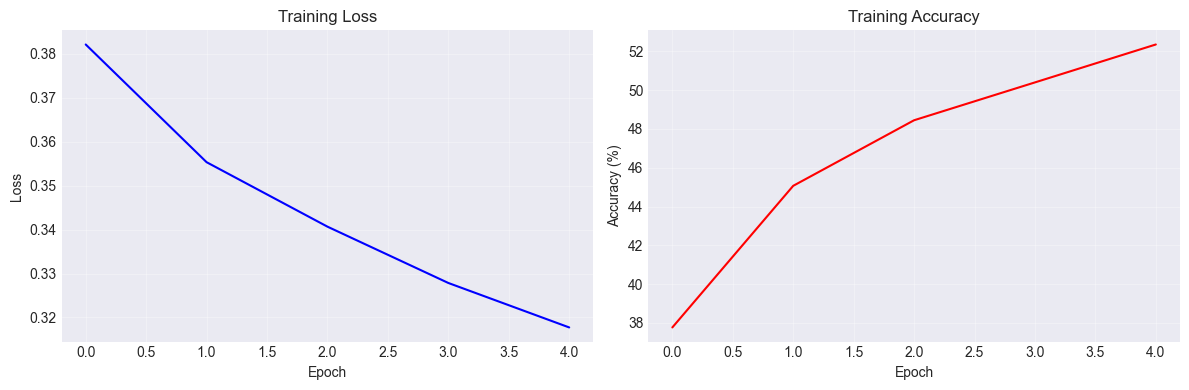

In [24]:
# Training function with live visualization
def train_cifar_mlp(epochs=10):
    model = CIFAR10_MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # For plotting
    train_losses = []
    train_accuracies = []
    
    print("Starting training...")
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        model.train()
        for i, (inputs, labels) in enumerate(trainloader):
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Print progress
            if i % 100 == 99:
                print(f'[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss/100:.3f}')
                running_loss = 0.0
        
        # Epoch statistics
        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(train_accuracy)
        
        print(f'Epoch {epoch+1} - Training Accuracy: {train_accuracy:.2f}%')
    
    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses, 'b-')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(train_accuracies, 'r-')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train for a few epochs (limited for demo)
trained_model = train_cifar_mlp(epochs=5)

## Evaluating on Test Data

Evaluate on held-out data to assess generalization.
- Small train/test gap: Good generalization
- Large gap: Overfitting

Overall Test Accuracy: 51.83%

Per-class Accuracy:
plane: 49.80%
car: 65.50%
bird: 36.40%
cat: 34.60%
deer: 43.60%
dog: 37.90%
frog: 70.20%
horse: 56.60%
ship: 72.40%
truck: 51.30%


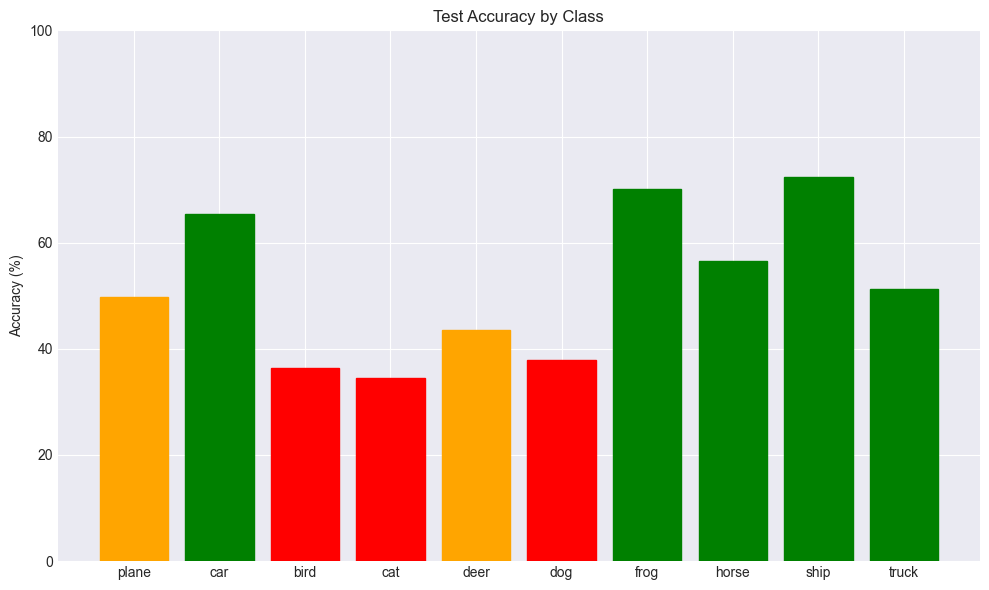

In [25]:
# Evaluate the model
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Overall accuracy
    overall_accuracy = 100 * correct / total
    print(f'Overall Test Accuracy: {overall_accuracy:.2f}%')
    
    # Per-class accuracy
    print('\nPer-class Accuracy:')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    class_accuracies = []
    for i in range(10):
        acc = 100 * class_correct[i] / class_total[i]
        class_accuracies.append(acc)
        print(f'{classes[i]}: {acc:.2f}%')
    
    # Bar plot
    bars = ax.bar(classes, class_accuracies)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Test Accuracy by Class')
    ax.set_ylim(0, 100)
    
    # Color bars based on performance
    for bar, acc in zip(bars, class_accuracies):
        if acc > 50:
            bar.set_color('green')
        elif acc > 40:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    plt.tight_layout()
    plt.show()
    
    return overall_accuracy

test_accuracy = evaluate_model(trained_model)

## Visualizing Learned Features

Examine first layer weights to see what patterns each neuron detects.


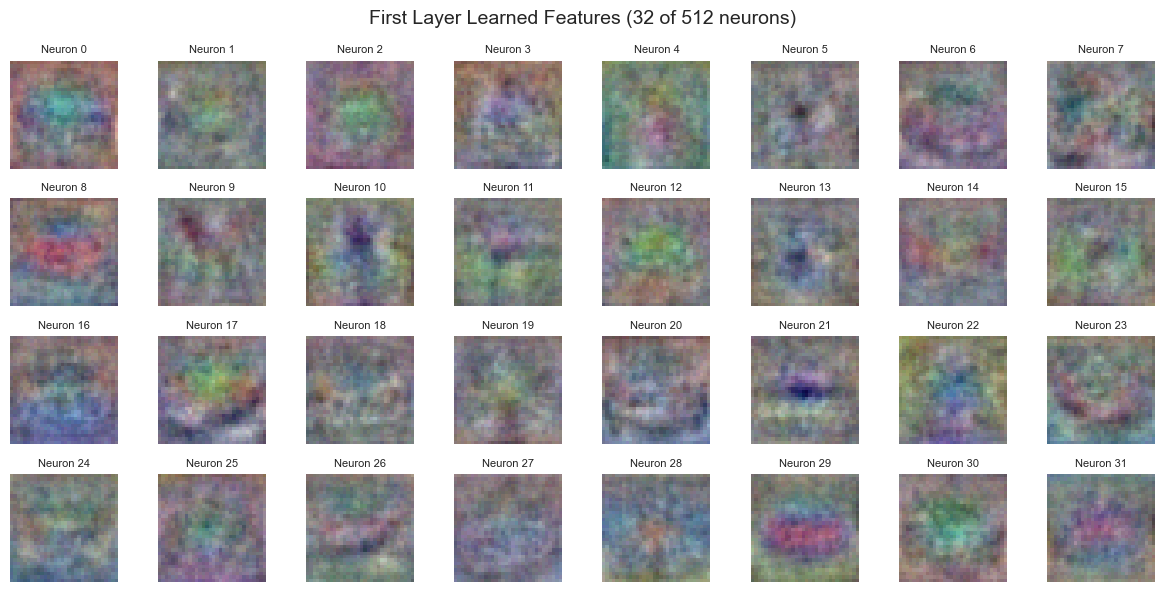

In [26]:
# Visualize first layer weights
def visualize_first_layer_weights(model):
    # Get first layer weights
    weights = model.fc1.weight.data
    
    # Reshape to image format (3072 -> 32x32x3)
    weights_reshaped = weights.view(weights.size(0), 3, 32, 32)
    
    # Normalize for visualization
    weights_norm = (weights_reshaped - weights_reshaped.min()) / \
                   (weights_reshaped.max() - weights_reshaped.min())
    
    # Plot subset of filters
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(min(32, weights.size(0))):
        img = weights_norm[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Neuron {i}', fontsize=8)
    
    plt.suptitle('First Layer Learned Features (32 of 512 neurons)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_first_layer_weights(trained_model)

Unlike CNNs, MLP features aren't spatially organized. Each neuron sees the entire flattened image.

# Section 8: Modern Practices

Key techniques for stable, effective training:


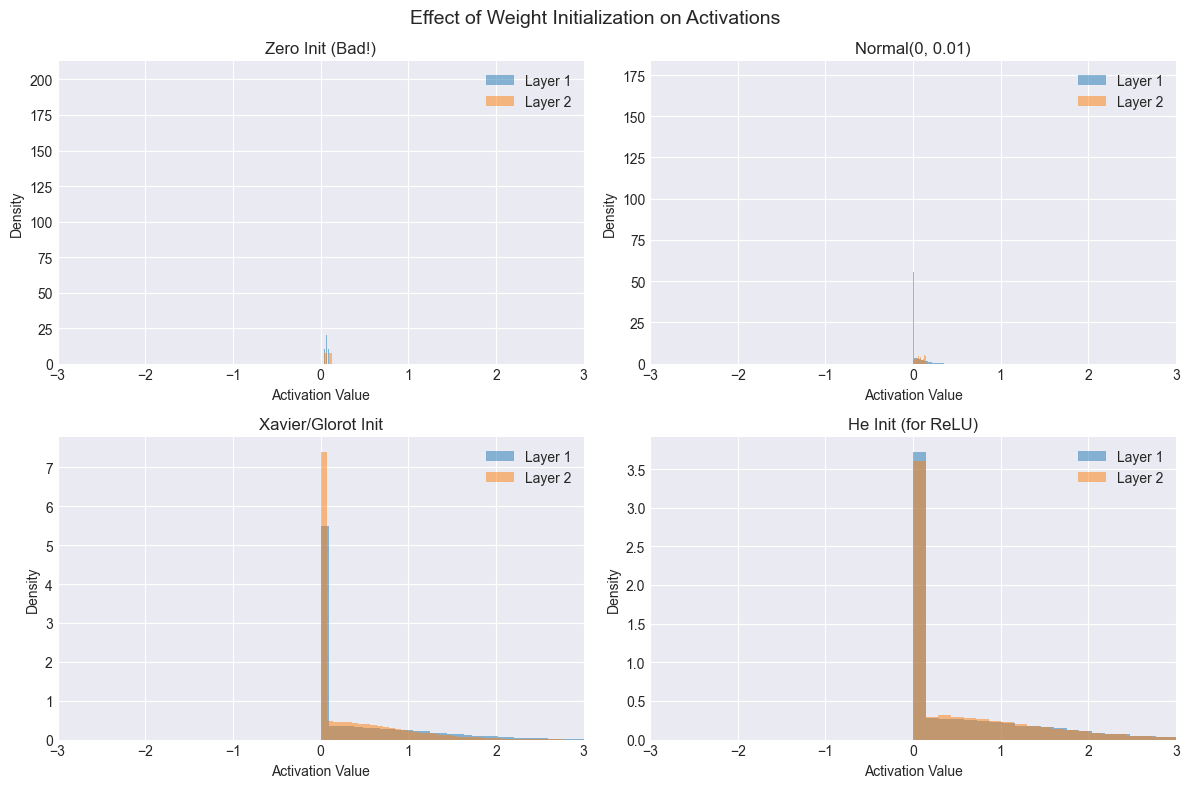

In [27]:
# Demonstrate different initialization methods
def compare_initializations():
    # Create networks with different initializations
    def create_network_with_init(init_type):
        model = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        
        for layer in model:
            if isinstance(layer, nn.Linear):
                if init_type == 'zeros':
                    nn.init.zeros_(layer.weight)
                elif init_type == 'normal':
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                elif init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        
        return model
    
    # Forward pass with random input
    x = torch.randn(1000, 100)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()
    
    init_types = ['zeros', 'normal', 'xavier', 'he']
    titles = ['Zero Init (Bad!)', 'Normal(0, 0.01)', 'Xavier/Glorot Init', 'He Init (for ReLU)']
    
    for idx, (init_type, title) in enumerate(zip(init_types, titles)):
        model = create_network_with_init(init_type)
        
        # Collect activations
        activations = []
        def hook(module, input, output):
            activations.append(output.detach())
        
        # Register hooks
        for layer in model:
            if isinstance(layer, nn.ReLU):
                layer.register_forward_hook(hook)
        
        # Forward pass
        _ = model(x)
        
        # Plot activation distributions
        ax = axes[idx]
        for i, act in enumerate(activations):
            act_flat = act.numpy().flatten()
            ax.hist(act_flat, bins=50, alpha=0.5, label=f'Layer {i+1}', density=True)
        
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_xlim(-3, 3)
    
    plt.suptitle('Effect of Weight Initialization on Activations', fontsize=14)
    plt.tight_layout()
    plt.show()

compare_initializations()

**Initialization matters:**
- Zero: Symmetry breaking fails
- Small normal: Activations vanish
- Xavier: Good for tanh/sigmoid
- He: Designed for ReLU

## Batch Normalization

Normalizes inputs to each layer (Ioffe & Szegedy, 2015):
$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}, \quad y_i = \gamma \hat{x}_i + \beta$$

Benefits: Higher learning rates, less sensitivity to initialization, faster convergence.

In [28]:
# Compare training with and without batch normalization
class MLPWithBatchNorm(nn.Module):
    def __init__(self, use_batchnorm=True):
        super(MLPWithBatchNorm, self).__init__()
        self.use_batchnorm = use_batchnorm
        
        self.fc1 = nn.Linear(3072, 512)
        self.bn1 = nn.BatchNorm1d(512) if use_batchnorm else nn.Identity()
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256) if use_batchnorm else nn.Identity()
        
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [29]:
# Quick comparison (limited epochs for demo)
model_no_bn = MLPWithBatchNorm(use_batchnorm=False)
optimizer_no_bn = optim.SGD(model_no_bn.parameters(), lr=0.01)

model_with_bn = MLPWithBatchNorm(use_batchnorm=True)
optimizer_with_bn = optim.SGD(model_with_bn.parameters(), lr=0.01)

# Note: Full training comparison omitted for time

# Connecting to Modern Architectures

All architectures use the same fundamentals: neurons, activations, forward propagation, and backpropagation.

**CNNs**: Local connections, weight sharing  
**RNNs**: Temporal connections, hidden state  
**Transformers**: Attention-based connections, parallelization


# Summary

1. Non-linearity is essential for deep networks
2. Universal approximation: NNs can approximate any continuous function
3. Forward propagation: Matrix operations + activations
4. Backpropagation: Chain rule applied backward
5. Modern practices: He/Xavier init, batch norm, dropout, Adam
6. All architectures (CNNs, RNNs, Transformers) build on these fundamentals
